In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


In [16]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
train_data = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
train_data.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


<Axes: xlabel='score', ylabel='count'>

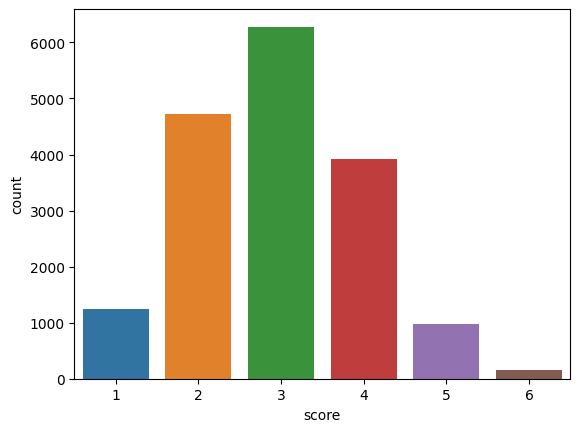

In [18]:
import seaborn as sns

sns.countplot(data=train_data, x = 'score')

In [19]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
#     text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text

In [20]:
train_data['cleaned_text'] = train_data['full_text'].apply(preprocess_text)
train_data.head()

,essay_id,full_text,score,cleaned_text
0,000d118,Many people have car where they live. The thin...,3,many people car live thing know use car alot t...
1,000fe60,I am a scientist at NASA that is discussing th...,3,scientist nasa discussing face mars explaining...
2,001ab80,People always wish they had the same technolog...,4,people always wish technology seen movies best...
3,001bdc0,"We all heard about Venus, the planet without a...",4,heard venus planet without almost oxygen earth...
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,dear state senator letter argue favor keeping ...


In [21]:
train_data_clean = train_data.drop(['essay_id', 'full_text'], axis='columns')
train_data_clean.head()

,score,cleaned_text
0,3,many people car live thing know use car alot t...
1,3,scientist nasa discussing face mars explaining...
2,4,people always wish technology seen movies best...
3,4,heard venus planet without almost oxygen earth...
4,3,dear state senator letter argue favor keeping ...


In [22]:
train_data_clean['score'] -= 1
train_data_clean.head()

,score,cleaned_text
0,2,many people car live thing know use car alot t...
1,2,scientist nasa discussing face mars explaining...
2,3,people always wish technology seen movies best...
3,3,heard venus planet without almost oxygen earth...
4,2,dear state senator letter argue favor keeping ...


In [23]:
max([len(x.split(' ')) for x in train_data_clean['cleaned_text']])

840

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [25]:
def tokenize_text(data):
    return tokenizer(
        data['cleaned_text'],
        padding=True,
        truncation = True
    )

In [26]:
import datasets

train_datasets = datasets.Dataset.from_pandas(train_data_clean)
train_datasets = train_datasets.rename_column('score', 'labels')
train_datasets

Dataset({
    features: ['labels', 'cleaned_text'],
    num_rows: 17307
})

In [27]:
train_data_encoding = train_datasets.map(tokenize_text, batched = True)
train_data_encoding

Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'cleaned_text', 'input_ids', 'attention_mask'],
    num_rows: 17307
})

In [28]:
data_splited = train_data_encoding.train_test_split(test_size=0.2, seed = 41)
data_splited

DatasetDict({
    train: Dataset({
        features: ['labels', 'cleaned_text', 'input_ids', 'attention_mask'],
        num_rows: 13845
    })
    test: Dataset({
        features: ['labels', 'cleaned_text', 'input_ids', 'attention_mask'],
        num_rows: 3462
    })
})

In [29]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='/kaggle/working/rating_model',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_strategy='steps',
    logging_steps=100,
    warmup_steps=200,
    num_train_epochs=3
)

2024-04-29 07:02:55.992885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 07:02:55.992977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 07:02:56.119300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [31]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [34]:
# # import evaluate
# # accuracy_metric = evaluate.load("accuracy")

# def compute_metric(y_true, y_pred):
#     N = y_true.shape[0]
#     O = torch.zeros(N, N)
#     for i in range(len(y_true)):
#         O[y_true[i], y_pred[i]] += 1
    
#     w = torch.zeros(N, N)
#     for i in range(N):
#         for j in range(N):
#             w[i, j] = ((i - j) ** 2) / ((N - 1) ** 2)
            
#     E = torch.outer(torch.histogram(y_true, bins=torch.arange(N+1))[0], torch.histogram(y_pred, bins=torch.arange(N+1))[0])
#     E = E / torch.sum(E)
    
#     num = torch.sum(w * O)
#     den = torch.sum(w * E)
#     kappa = 1 - num / den
#     return kappa.item()
import evaluate
accuracy_metric = evaluate.load("accuracy")

def compute_metric(eval_pred):
   """Computes accuracy score for one epoch."""
   predictions, labels = eval_pred
   predictions = np.argmax(predictions, axis=1)

   return accuracy_metric.compute(predictions=predictions, references=labels)

In [42]:
CUDA_LAUNCH_BLOCKING=1

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_splited['train'],
    eval_dataset=data_splited['test'],
    compute_metrics=compute_metric
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [36]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ······················


wandb: ERROR API key must be 40 characters long, yours was 22
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
100,1.448100
200,1.102400
300,1.012900
400,0.935900
500,0.889700
600,0.864400
700,0.827700
800,0.830700
900,0.800500
1000,0.734700


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1299, training_loss=0.8887131230660454, metrics={'train_runtime': 1091.9368, 'train_samples_per_second': 38.038, 'train_steps_per_second': 1.19, 'total_flos': 5502425886996480.0, 'train_loss': 0.8887131230660454, 'epoch': 3.0})

In [37]:
test_data = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
test_data.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [38]:
test_data['cleaned_text'] = test_data['full_text'].apply(preprocess_text)
test_data.head()

,essay_id,full_text,cleaned_text
0,000d118,Many people have car where they live. The thin...,many people car live thing know use car alot t...
1,000fe60,I am a scientist at NASA that is discussing th...,scientist nasa discussing face mars explaining...
2,001ab80,People always wish they had the same technolog...,people always wish technology seen movies best...


In [39]:
test_data_clean = test_data.drop(['full_text'], axis='columns')
test_data_clean.head()

,essay_id,cleaned_text
0,000d118,many people car live thing know use car alot t...
1,000fe60,scientist nasa discussing face mars explaining...
2,001ab80,people always wish technology seen movies best...


In [40]:
test_datasets = datasets.Dataset.from_pandas(test_data_clean)
test_datasets

Dataset({
    features: ['essay_id', 'cleaned_text'],
    num_rows: 3
})

In [41]:
test_data_encoding = test_datasets.map(tokenize_text, batched=True)
test_data_encoding

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Dataset({
    features: ['essay_id', 'cleaned_text', 'input_ids', 'attention_mask'],
    num_rows: 3
})

In [42]:
test_prediction = trainer.predict(test_data_encoding)
test_prediction

PredictionOutput(predictions=array([[ 2.4606752 ,  2.692396  ,  1.448919  , -1.2028743 , -3.7857177 ,
        -3.987293  ],
       [-0.06634297,  3.955593  ,  2.7707999 , -1.9750091 , -4.1361294 ,
        -4.0187654 ],
       [-3.3087633 , -2.0585182 ,  1.1926724 ,  3.3570907 ,  0.9382093 ,
        -3.0301497 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.0707, 'test_samples_per_second': 42.457, 'test_steps_per_second': 14.152})

In [45]:
test_pre = np.argmax(test_prediction.predictions, axis = 1)
test_pre += 1
test_pre

array([2, 2, 4])

In [46]:
results = pd.DataFrame({'essay_id': test_data['essay_id'], 'score': test_pre})
results.head()

,essay_id,score
0,000d118,2
1,000fe60,2
2,001ab80,4


In [47]:
results.to_csv('/kaggle/working/submission.csv', index=False)